In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload file kaggle.json yang berisi API key
files.upload()

# Pindahkan file kaggle.json ke direktori yang benar
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set izin untuk file kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

fruits-fresh-and-rotten-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Ekstrak dataset yang diunduh
!unzip -qo fruits-fresh-and-rotten-for-classification.zip -d /content/dataset
dataset_path = '/content/dataset'

In [ ]:
# Manipulasi Data
import numpy as np
import pandas as pd
# Visualisasi
import matplotlib.pyplot as plt
# Eksplorasi Dataset
import os
# Generasi Dataset
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
# Transfer Learning
from keras.applications import ResNet50 #Awalnya adalah VGG16
# Optimizer
from keras.optimizers import Adam
# Layer Keras
from keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
# Model Keras
from keras.models import Model

# Mendefinisikan kelas dan menghitung jumlah instansinya
classes = []
class_counter = 0

for dirname, _, filenames in os.walk('/content/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1

print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

rottenbanana    2224           
rottenoranges   1595           
freshbanana     1581           
freshoranges    1466           
rottenapples    2342           
freshapples     1693           


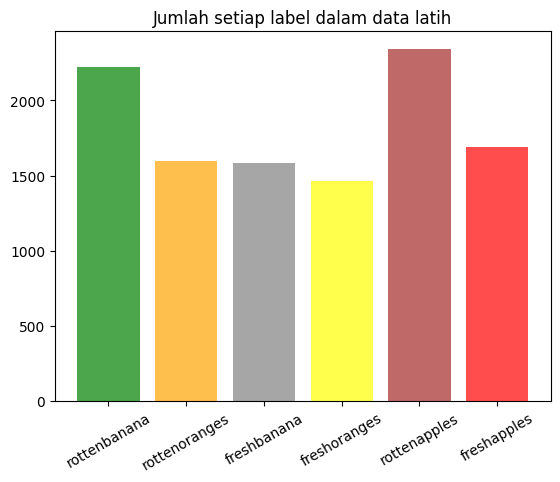

In [ ]:
# Menampilkan grafik batang untuk distribusi kelas pada data latih
counts = []
labels = []
for d in classes:
    [(k, v)] = d.items()
    labels.append(k)
    counts.append(v)

plt.figure()
plt.bar(range(len(counts)), counts, color=['green', 'orange', 'grey', 'yellow', 'brown', 'red'], alpha=0.7)
plt.xticks(range(len(counts)), labels, rotation=30)
plt.title('Jumlah setiap label dalam data latih')
plt.show()


In [ ]:
# Path untuk data latih dan data uji
TRAIN_PATH = '/content/dataset/train'
TEST_PATH = '/content/dataset/test'

# Membuat objek ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=.3
)

# Menghasilkan dataset latih dan validasi menggunakan ImageDataGenerator
train_ds = datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

validation_ds = datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)


Found 7634 images belonging to 6 classes.
Found 3267 images belonging to 6 classes.


In [ ]:
# Menggunakan model ResNet50 (Awalnya VGG16) sebagai base model untuk transfer learning
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet50.trainable = False

# Membangun model dengan menambahkan lapisan kustom di atas ResNet50
X_input = Input(shape=(224, 224, 3))
X = resnet50(X_input)
X = AveragePooling2D(pool_size=(3, 3), strides=2, padding='valid', name='AvgPool2D')(X)
X = Flatten(name='Flatten')(X)
X = Dense(200, activation='relu', name='Dense1')(X)
X = Dropout(0.1)(X)
X = Dense(100, activation='relu', name='Dense2')(X)
X = Dropout(0.1)(X)
X = Dense(6, activation='softmax', name='Dense3')(X)

model = Model(inputs=X_input, outputs=X, name='Fruit_Classifier')

print(model.summary())


Model: "Fruit_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 AvgPool2D (AveragePooling2  (None, 3, 3, 2048)        0         
 D)                                                              
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 Dense1 (Dense)              (None, 200)               3686600   
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                  

In [ ]:
# Mengkompilasi model dengan optimizer Adam dan fungsi loss categorical_crossentropy
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model pada dataset latih dan validasi
hist = model.fit(train_ds, validation_data=validation_ds, epochs=8, batch_size=32)


Epoch 1/8
239/239 [==============================] - 179s 716ms/step - loss: 0.5741 - accuracy: 0.8584 - val_loss: 0.1451 - val_accuracy: 0.9529
Epoch 2/8
239/239 [==============================] - 170s 712ms/step - loss: 0.1941 - accuracy: 0.9362 - val_loss: 0.0698 - val_accuracy: 0.9749
Epoch 3/8
239/239 [==============================] - 167s 701ms/step - loss: 0.1571 - accuracy: 0.9469 - val_loss: 0.0583 - val_accuracy: 0.9801
Epoch 4/8
239/239 [==============================] - 168s 703ms/step - loss: 0.1187 - accuracy: 0.9608 - val_loss: 0.0457 - val_accuracy: 0.9853
Epoch 5/8
239/239 [==============================] - 168s 705ms/step - loss: 0.1130 - accuracy: 0.9604 - val_loss: 0.0372 - val_accuracy: 0.9875
Epoch 6/8
239/239 [==============================] - 165s 693ms/step - loss: 0.0923 - accuracy: 0.9699 - val_loss: 0.0324 - val_accuracy: 0.9887
Epoch 7/8
239/239 [==============================] - 164s 686ms/step - loss: 0.0868 - accuracy: 0.9726 - val_loss: 0.0230 - val_ac

1/1 [==============================] - 0s 67ms/step


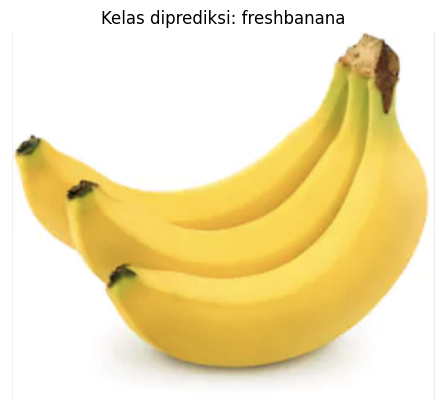

Kelas diprediksi: freshbanana
Probabilitas prediksi: [1.3002360e-24 1.0000000e+00 1.1156447e-22 3.7311026e-30 5.3068583e-20
 7.2432795e-26]


In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import matplotlib.image as mpimg

# Memuat gambar baru untuk diprediksi
new_image_path = '/content/dataset/test/freshbanana/Screen Shot 2018-06-12 at 9.41.30 PM.png'  # Ganti path gambar
img = image.load_img(new_image_path, target_size=(224, 224))  # Perbarui target_size ke (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Membuat prediksi
predictions = model.predict(img_array)

# Mendapatkan indeks kelas yang diprediksi
predicted_class_index = np.argmax(predictions)

# Mendapatkan label kelas
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Menampilkan gambar dan hasil prediksi
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Kelas diprediksi: {predicted_class_label}')
plt.show()

# Menampilkan hasil prediksi
print(f'Kelas diprediksi: {predicted_class_label}')
print(f'Probabilitas prediksi: {predictions[0]}')
